# Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
import transformers
from datasets import load_dataset
#import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

import torch
import torchvision

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_memory_growth(gpus[0], True)
#     except:
#         pass

# Data

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

In [3]:
DATASET_FOLDER = 'dataset'
TRANSFORMER_IMG_SIZE = (224, 224)

In [4]:
# class TiledDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, tile_size):
#         super().__init__()
#         self.dataset = dataset
#         self.tile_size = tile_size

#     def split_img_to_tiles(self, image):
#         c, H, W = image.shape
#         tiles = []
#         n_x = math.ceil((W - self.tile_size[1]) / (self.tile_size[1] - 1)) + 1
#         n_y = math.ceil((H - self.tile_size[0]) / (self.tile_size[0] - 1)) + 1
#         step_x = self.tile_size[1] if W % self.tile_size[1] else (W - self.tile_size[1]) / (n_x - 1)
#         step_y = self.tile_size[0] if H % self.tile_size[0] else (H - self.tile_size[0]) / (n_y - 1) 
        
#         for x in range(0, W, step_x):
#             for y in range(0, H, step_y):
#                 tiles.append(torchvision.transforms.functional.crop(image, y, x, self.tile_size[0], self.tile_size[1]))

#         return tiles
    
#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         image, label = dataset[idx]

#         tiles = self.split_img_to_tiles(image)
#         return tiles, [label] * len(tiles)

In [5]:
# def collate_fn(batch):
#     tiles = []
#     labels = []
#     for tile_list, label in batch:
#         tiles.extend(tile_list)
#         labels.extend(label)
#     return torch.stack(tiles), torch.tensor(labels)

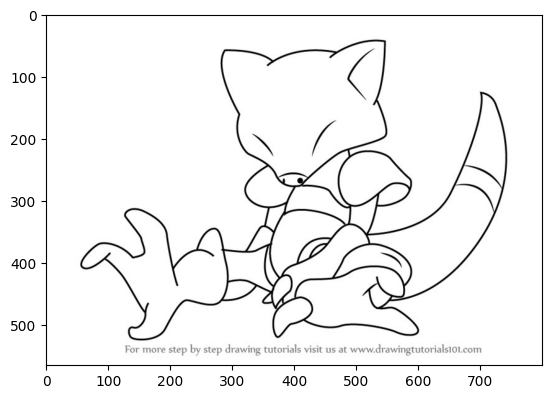

In [78]:
plt.imshow(torch.permute(dataset[1][0], [1, 2, 0]))

In [100]:
transforms = torchvision.transforms.Compose(
                    [torchvision.transforms.ToTensor(),
                     torchvision.transforms.Resize(TRANSFORMER_IMG_SIZE)])
dataset = torchvision.datasets.ImageFolder(DATASET_FOLDER, transform=transforms)
#ds = TiledDataset(dataset, (256, 256))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)
next(iter(dataset))[0].shape

torch.Size([3, 224, 224])

In [6]:
dataset = load_dataset("imagefolder", data_dir='dataset/')['train']

# Backbone

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [7]:
backbone = transformers.AutoModel.from_pretrained('google/vit-base-patch16-224-in21k')

Load tokenizer to be used with the model

In [8]:
processor = transformers.AutoImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Run the backbone on the images and save the extracted features. Don't forget to process the images. Images don't have to be of the same size, though it would be faster if they were. If the images don't fit in memory, lazily load them from disk

In [9]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
size = (
    processor.size["shortest_edge"]
    if "shortest_edge" in processor.size
    else (processor.size["height"], processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [10]:
def transforms(examples):
    examples["image"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    return examples

In [11]:
dataset = dataset.with_transform(transforms)

In [ ]:
dataset['image'][0]

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
processed_imgs = processor(dataset[0])

ValueError: Invalid image type. Expected either PIL.Image.Image, numpy.ndarray, torch.Tensor, tf.Tensor or jax.ndarray, but got <class 'dict'>.

# Prepare train/test data

Split your data (extracted features and labels) into train and test subsets.

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [ ]:
train_X = tf.data.Dataset.from_tensor_slices(X_train)
train_y = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_X, train_y)).batch(128)

test_X = tf.data.Dataset.from_tensor_slices(X_test)
test_y = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_X, test_y)).batch(128)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layers with weights.

Compile the model. Choose loss and metrics.

# Train the model

# Evaluation

Evalute the model on test data.

Plot confusion matrix.

Perform dimensiality reduction and plot the extracted features. Do classes form clusters?

# Bonus

Check if the feature extractor model can be used without a classifier layer (how large is the average feature vector similarity inbetween same in different classes)